# Test results analysis

## Prepare data

* Download results

In [ ]:
from paramiko import SSHClient
from scp import SCPClient 
import requests as r

USER='hadoop'
HOST='172.16.4.135'
PASSWD='hadoop'
REMOTE_WORKING_DIR = 'bloom'
REMOTE_LOGS=f'/home/{USER}/{REMOTE_WORKING_DIR}/logs'
LOGS='data/logs'

client = SSHClient()
client.load_system_host_keys()
client.connect(hostname=HOST, username=USER, password=PASSWD)
scp = SCPClient(client.get_transport())
scp.get(REMOTE_LOGS, recursive=True, local_path='data/')
scp.close()
client.close()

* Load data

In [2]:
import json
import glob
hadoop_log_filename = glob.glob("data/logs/hadoop_log*.json")[-1]
spark_log_filename = glob.glob("data/logs/spark_log*.json")[-1]

hadoop_logs = {}
spark_logs = {}

with open(hadoop_log_filename) as js:
    hadoop_logs = json.load(js)

with open(hadoop_log_filename, 'w') as js:
   json.dump(hadoop_logs, js, indent=2)
   
with open(spark_log_filename) as js:
    spark_logs = json.load(js)

with open(spark_log_filename, 'w') as js:
   json.dump(spark_logs, js, indent=2)


* Hadoop data

In [3]:
from datetime import datetime 
import numpy as np
import pandas as pd

start = datetime.strptime(hadoop_logs['start'], '%d-%m-%Y_%H.%M.%S')
stop = datetime.strptime(hadoop_logs['stop'], '%d-%m-%Y_%H.%M.%S')
total_time = stop - start

print(f'Total execution time: {total_time}')

with_bloom_filter = hadoop_logs['tests']['WithBloomFilters']
with_indexes = hadoop_logs['tests']['WithIndexes']

wall_time = {'withBloomFilter':0,'withIndexes':0}
for test in with_bloom_filter:
    wall_time['withBloomFilter'] += np.sum(pd.DataFrame(with_bloom_filter[test])['wallTime'])

for test in with_indexes:
    wall_time['withIndexes'] += np.sum(pd.DataFrame(with_indexes[test])['wallTime'])

print('Version delta time (Indexes-Bloom): ' + 
        f"{round((wall_time['withIndexes'] - wall_time['withBloomFilter']) / 10 ** 9 / 60, 2)} minutes")

Total execution time: 5:31:54
Version delta time (Indexes-Bloom): 11.72 minutes


* Spark data

In [5]:
from datetime import datetime 
import numpy as np
import pandas as pd

start = datetime.strptime(spark_logs['start'], '%d-%m-%Y_%H.%M.%S')
stop = datetime.strptime(spark_logs['stop'], '%d-%m-%Y_%H.%M.%S')
total_time = stop - start

print(f'Total execution time: {total_time}')

with_bloom_filter = spark_logs['tests']['WithBloomFilters']
with_indexes = spark_logs['tests']['WithIndexes']

wall_time = {'withBloomFilter':0,'withIndexes':0}
for test in with_bloom_filter:
    wall_time['withBloomFilter'] += np.sum(pd.DataFrame(with_bloom_filter[test])['wallTime'])

for test in with_indexes:
    wall_time['withIndexes'] += np.sum(pd.DataFrame(with_indexes[test])['wallTime'])

print('Version delta time (Indexes-Blooom): ' + 
        f"{round((wall_time['withIndexes'] - wall_time['withBloomFilter']) / 10 ** 9 / 60, 2)} minutes")

Total execution time: 8:16:19
Version delta time (Indexes-Blooom): 22.88 minutes


* Aggregate hadoop data

In [4]:
from numpy import char as npc

avg_wall_time = 0
hadoop_aggregate = {}
with open ('data/hadoop_aggregate.txt','w') as out:
    for version, version_name in zip([with_bloom_filter, with_indexes],['WithBloomFilters','WithIndexes']):
        for test_name in version:
            out.write(f"\n************** {version_name} {test_name} **************\n\n")
            test = pd.DataFrame(version[test_name])
            wall_time = round(np.average(test['wallTime']) / 10**9, 2)
            vector_logs = npc.array(test['log'])
            partitions = npc.partition(test['log'].to_list(), 'File System Counters\n')
            metrics = [metric[-1] for metric in partitions]
            metrics = npc.splitlines(metrics)
            metrics = [(npc.split(npc.strip(metric), '=')) for metric in metrics]
            metrics = [filter(lambda m: len(m) == 2, metric) for metric in metrics]
            metrics =[dict([(m[0],float(m[1])) for m in metric]) for metric in metrics]

            metrics_df = pd.DataFrame(metrics)
            aggregate_metrics = {'wallTime':{
                'avg': round(np.average(test['wallTime'] / 10**9), 2),
                'max': round(np.max(test['wallTime'] / 10**9), 2),
                'min': round(np.min(test['wallTime'] / 10**9), 2),
                'var': round(np.var(test['wallTime'] / 10**9), 2),
                'std': round(np.std(test['wallTime'] / 10**9), 2)}}
            
            out.write(f"{f'{test_name}, wall time:':75} {wall_time}\n")
            for m in metrics[0]:
               
                aggregate_metrics[m]={
                    'avg': round(np.average(metrics_df[m]),2), 
                    'max': round(np.max(metrics_df[m]),2), 
                    'min': round(np.min(metrics_df[m]),2),
                    'var': round(np.var(metrics_df[m]),2),
                    'std': round(np.std(metrics_df[m]),2)
                }
                if m == 'Killed map tasks': 
                    aggregate_metrics[m]['avg'] = 'Nan'         
                    
                out.write(f"{f'{test_name}, {m}:':75} {np.average(metrics_df[m]), np.max(metrics_df[m]), np.min(metrics_df[m])}\n")

            hadoop_aggregate[f'{version_name}{test_name}'] = aggregate_metrics
            
with open('data/hadoop_aggregate.json','w') as out:
    json.dump(hadoop_aggregate, out, indent=2)

* Aggregate spark data

In [6]:
from numpy import char as npc

avg_wall_time = 0
spark_aggregate = {}
with open ('data/spark_aggregate.txt','w') as out:
    for version, version_name in zip([with_bloom_filter, with_indexes],['WithBloomFilters','WithIndexes']):
        for test_name in version:
            out.write(f"\n************** {version_name} {test_name} **************\n\n")
            test = pd.DataFrame(version[test_name])
            wall_time = round(np.average(test['wallTime']) / 10**9, 2)
            
            aggregate_metrics = {'wallTime':{
                'avg': round(np.average(test['wallTime'] / 10**9), 2),
                'max': round(np.max(test['wallTime'] / 10**9), 2),
                'min': round(np.min(test['wallTime'] / 10**9), 2),
                'var': round(np.var(test['wallTime'] / 10**9), 2),
                'std': round(np.std(test['wallTime'] / 10**9), 2)}}
            
            out.write(f"{f'{test_name}, wall time:':75} {wall_time}\n")
            spark_aggregate[f'{version_name}{test_name}'] = aggregate_metrics

with open('data/spark_aggregate.json','w') as out:
    json.dump(spark_aggregate, out, indent=2)

## Plot data

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs("data/plots", exist_ok=True)

INTERACTIVE=True
IGNORE_X=False
COLORS = sns.color_palette(None, 10) 

plt.rcParams["figure.figsize"] = [15, 7.5]
plt.rcParams["figure.autolayout"] = False

def plot_data(filename, x_series, y_series, legend, labels, title='', colors=COLORS, scale='linear', auto_range=False, err=None, **kwargs):
            
    for data, label, color in zip(y_series, legend, colors):
        x = range(0, len(data)) if x_series is None or IGNORE_X else x_series
        if err is not None:
            plt.errorbar(x, data, err, linestyle='None', color=color, capsize=3)
        plt.plot(x, data, label=label, color=color, marker = 'o', **kwargs)

    
    plt.legend()
    plt.grid(axis='y', linestyle=(0,(1,5)), color='black')
    plt.title(title, fontsize=18, weight='bold')
    
    if auto_range == False:
        plt.ylim(bottom=0)
        
    plt.xlabel(labels[0],fontsize=12, style='italic')
    plt.ylabel(labels[1],fontsize=12, style='italic')   
    plt.yscale(scale)
   
    plt.savefig(f"data/plots/{filename}.pdf")
    plt.savefig(f"data/plots/{filename}.png")
    
    if INTERACTIVE:
        plt.show()

    plt.close()


### Map Output Bytes

* Map output bytes over K

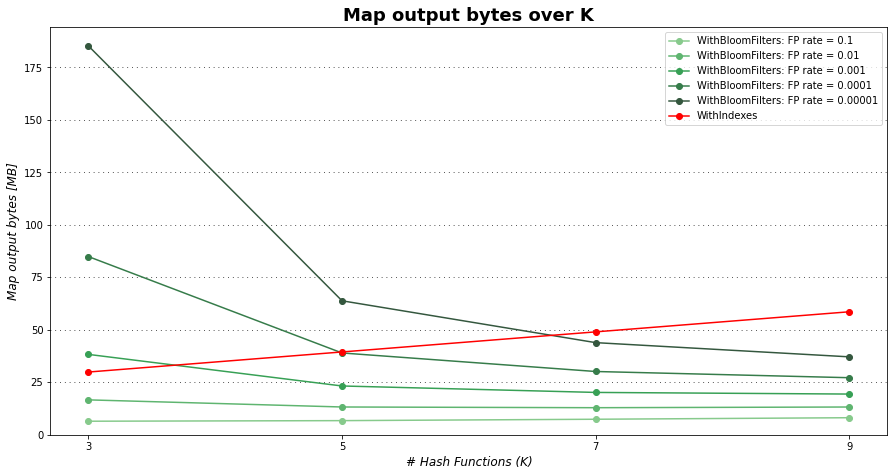

In [10]:
P = ['0.1', '0.01', '0.001', '0.0001', '0.00001']
K = ['3', '5', '7', '9']

bloom = [[round(hadoop_aggregate[f'WithBloomFiltersP{p}K{k}']['Map output bytes']['avg']/2**20, 2) for k in K] for p in P]
indexes = [[round(hadoop_aggregate[f'WithIndexesP{p}K{k}']['Map output bytes']['avg']/2**20, 2) for k in K] for p in P]
data = bloom + indexes
legend = [f'{version}: FP rate = {p}' for version in ['WithBloomFilters'] for p in P ]
legend.append('WithIndexes')

plot_data('MapOutputBytesK', K, data, legend, ['# Hash Functions (K)', 'Map output bytes [MB]'], 
          title='Map output bytes over K', colors=sns.color_palette('Greens_d', 5) + ['red'] )

    

* Map output bytes over P

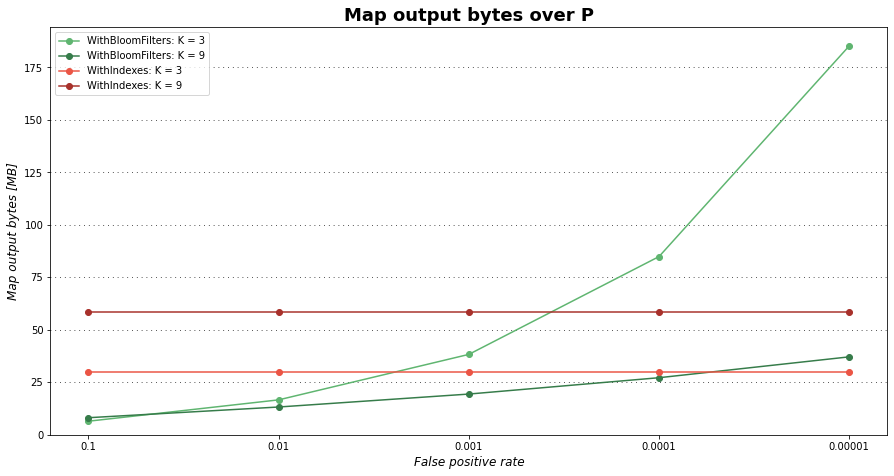

In [11]:
P = ['0.1', '0.01', '0.001', '0.0001', '0.00001']
K = ['3', '9']

bloom = [[round(hadoop_aggregate[f'WithBloomFiltersP{p}K{k}']['Map output bytes']['avg']/2**20, 2) for p in P] for k in K]
indexes = [[round(hadoop_aggregate[f'WithIndexesP{p}K{k}']['Map output bytes']['avg']/2**20, 2) for p in P] for k in K]
data = bloom + indexes
legend = [f'{version}: K = {k}' for version in ['WithBloomFilters', 'WithIndexes'] for k in K ]
#legend.append('WithIndexes')

plot_data('MapOutputBytesP', P, data, legend, ['False positive rate', 'Map output bytes [MB]'], 
          title='Map output bytes over P', colors=sns.color_palette('Greens_d', 2) + sns.color_palette('Reds_d', 2) )

* Map output bytes rate over K

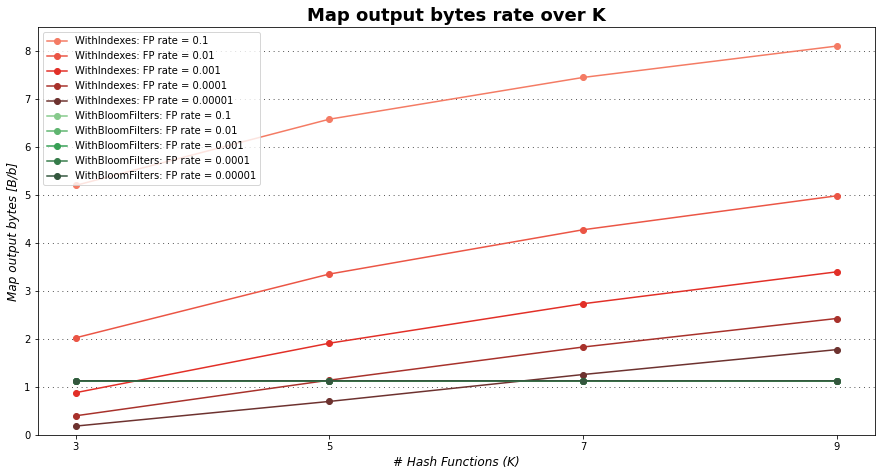

In [12]:
with open('data/parameters.json') as pf:
    params = json.load(pf)
    
K = ['3', '5', '7', '9']
P = ['0.1', '0.01', '0.001', '0.0001', '0.00001']

bloom = [[round(hadoop_aggregate[f'WithBloomFiltersP{p}K{k}']['Map output bytes']['avg']) for k in K] for p in P]
indexes = [[round(hadoop_aggregate[f'WithIndexesP{p}K{k}']['Map output bytes']['avg']) for k in K] for p in P]

M = [[np.sum(params[f'P{p}K{k}']['M']) for k in K] for p in P]
data = []


for m, mob in zip(M, indexes):
    data.append([x/y for x,y in zip(mob,m)])
    
for m, mob in zip(M, bloom):
    data.append([x/y for x,y in zip(mob,m)])
 
legend = [f'{version}: FP rate = {p}' for version in ['WithIndexes', 'WithBloomFilters'] for p in P ]

plot_data('MapOutputBytesRateK', K, data, legend, ['# Hash Functions (K)', 'Map output bytes [B/b]'], 
          title='Map output bytes rate over K', colors = sns.color_palette('Reds_d', 5)+ sns.color_palette('Greens_d', 5))


* Map output bytes rate over P

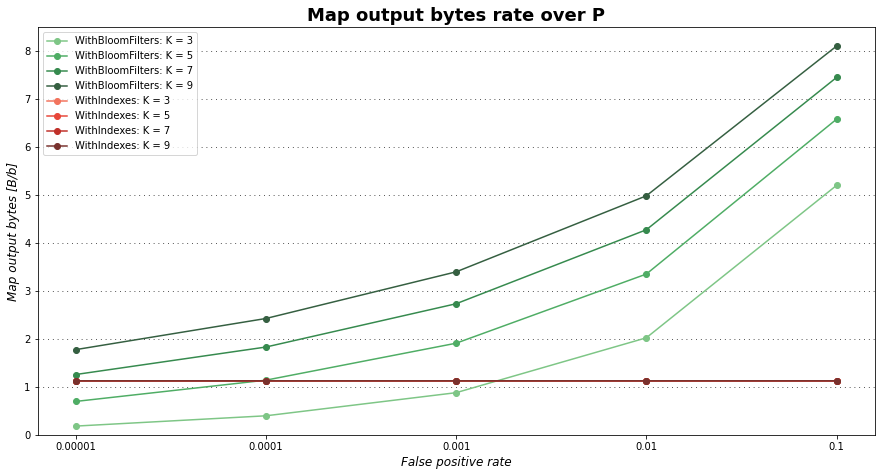

In [13]:
with open('data/parameters.json') as pf:
    params = json.load(pf)
    
K = ['3', '5', '7', '9']
P = ['0.00001', '0.0001', '0.001', '0.01','0.1']

bloom = [[round(hadoop_aggregate[f'WithBloomFiltersP{p}K{k}']['Map output bytes']['avg']) for p in P] for k in K]
indexes = [[round(hadoop_aggregate[f'WithIndexesP{p}K{k}']['Map output bytes']['avg']) for p in P] for k in K]

M = [[np.sum(params[f'P{p}K{k}']['M']) for p in P] for k in K]
data = []


for m, mob in zip(M, indexes):
    data.append([x/y for x,y in zip(mob,m)])
    
for m, mob in zip(M, bloom):
    data.append([x/y for x,y in zip(mob,m)])
    
legend = [f'{version}: K = {k}' for version in ['WithBloomFilters','WithIndexes'] for k in K ] + ['WithBloomFilters']

plot_data('MapOutputBytesRateP', P, data, legend, ['False positive rate', 'Map output bytes [B/b]'], 
          title='Map output bytes rate over P', colors = sns.color_palette('Greens_d', 4) + sns.color_palette('Reds_d', 4))

* Map output bytes over P, best K

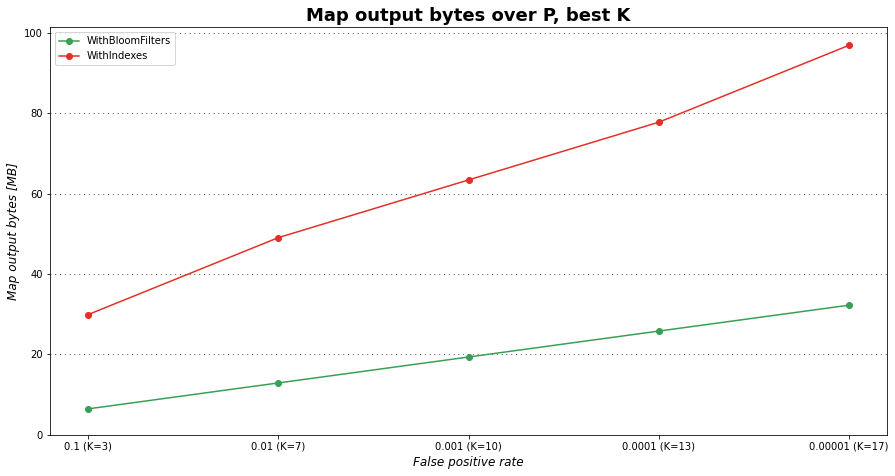

In [38]:
P = ['0.1', '0.01', '0.001', '0.0001', '0.00001']
K = ['0']
X = [f"{p} (K={params[f'P{p}K0']['K']})" for p in ['0.1','0.01','0.001','0.0001','0.00001']]

bloom = [[round(hadoop_aggregate[f'WithBloomFiltersP{p}K{k}']['Map output bytes']['avg']/2**20, 2) for p in P] for k in K]
indexes = [[round(hadoop_aggregate[f'WithIndexesP{p}K{k}']['Map output bytes']['avg']/2**20, 2) for p in P] for k in K]
data = bloom + indexes
legend = [f'{version}' for version in ['WithBloomFilters', 'WithIndexes']]

plot_data('MapOutputBytesP_bestK', X, data, legend, ['False positive rate', 'Map output bytes [MB]'], 
          title='Map output bytes over P, best K', colors=sns.color_palette('Greens_d', 1) + sns.color_palette('Reds_d', 1) )

* Map output bytes over M, best K

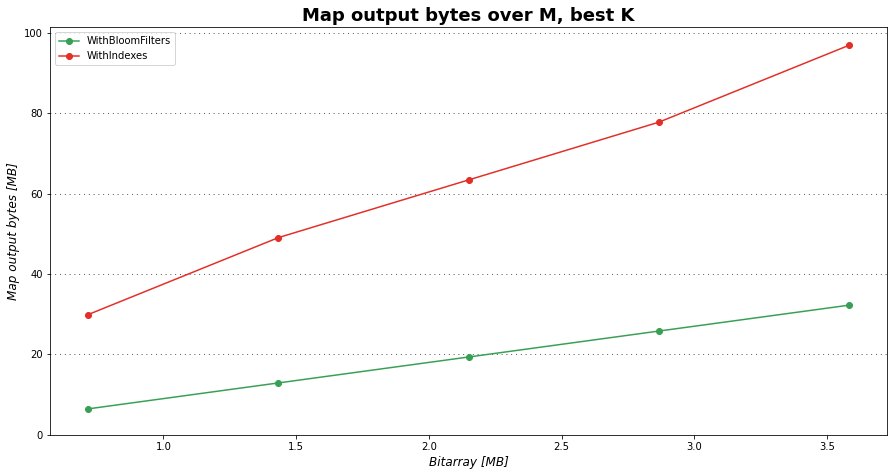

In [15]:
P = ['0.1', '0.01', '0.001', '0.0001', '0.00001']
K = ['0']
M = [np.sum(m)/2**23 for m in [params[f'P{p}K0']['M'] for p in P]]

bloom = [[round(hadoop_aggregate[f'WithBloomFiltersP{p}K{k}']['Map output bytes']['avg']/2**20, 2) for p in P] for k in K]
indexes = [[round(hadoop_aggregate[f'WithIndexesP{p}K{k}']['Map output bytes']['avg']/2**20, 2) for p in P] for k in K]
data = bloom + indexes
legend = [f'{version}' for version in ['WithBloomFilters', 'WithIndexes']]

plot_data('MapOutputBytesM_bestK', M, data, legend, ['Bitarray [MB]', 'Map output bytes [MB]'], 
          title='Map output bytes over M, best K', colors=sns.color_palette('Greens_d', 1) + sns.color_palette('Reds_d', 1))

* Map output bytes over MAP

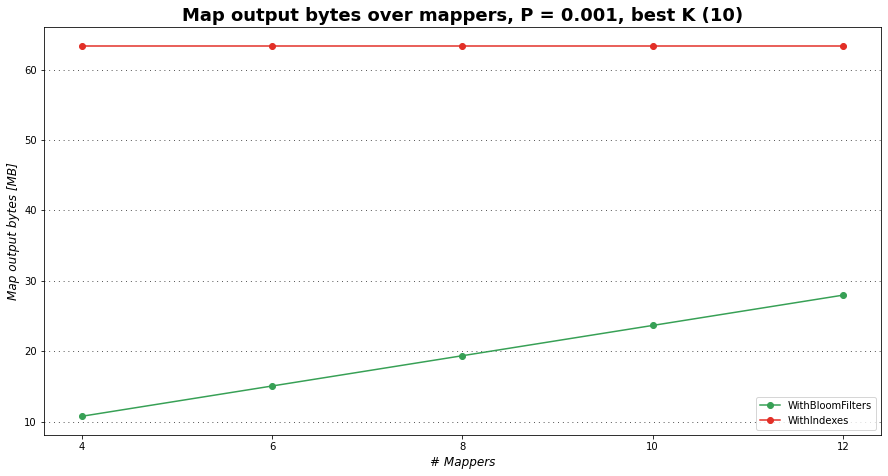

In [27]:
MAP = ['4', '6', '8', '10', '12']
MAP_P = '0.001'
MAP_K = '0'
VERSIONS = ['WithBloomFilters', 'WithIndexes']
data = [[hadoop_aggregate[f'{version}P{MAP_P}K{MAP_K}MAP{m}']['Map output bytes']['avg']/2**20 for m in MAP] for version in VERSIONS]

legend = [f'{version}' for version in VERSIONS]

plot_data('MapOutputBytesMappers', MAP, data, legend, ['# Mappers', 'Map output bytes [MB]'], 
          title=f'Map output bytes over mappers, P = {MAP_P}, best K ({params["P0.001K0MAP4"]["K"]})', colors=sns.color_palette('Greens_d', 1) + sns.color_palette('Reds_d', 1), auto_range=True)

### Wall time

* Wall time over K

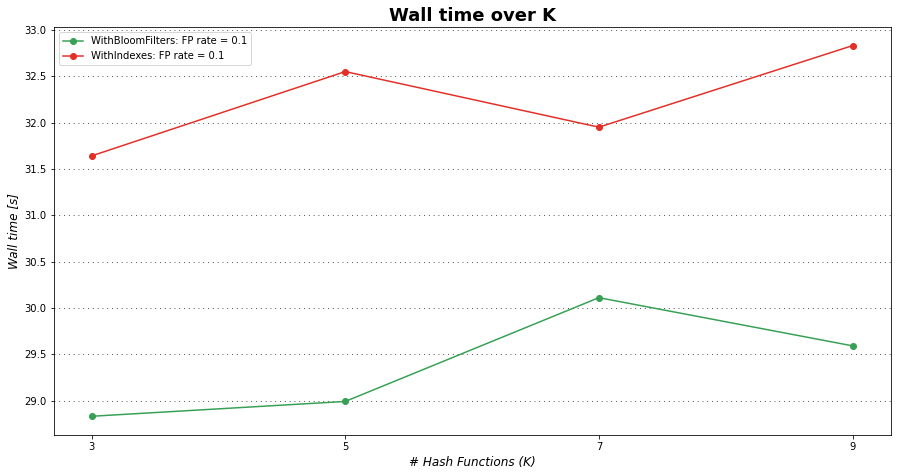

In [18]:
K = ['3', '5', '7', '9']
P = ['0.1']
VERSIONS = ['WithBloomFilters','WithIndexes']

wallTime = [[hadoop_aggregate[f'WithBloomFiltersP{p}K{k}']['wallTime']['avg'] for k in K] for p in P] + \
                [[hadoop_aggregate[f'WithIndexesP{p}K{k}']['wallTime']['avg'] for k in K] for p in P]

legend = [f'{version}: FP rate = {p}' for version in VERSIONS for p in P ]

plot_data('hadoop_wallTimeK', K, wallTime, legend, ['# Hash Functions (K)', 'Wall time [s]'], 
          title='Wall time over K', colors=sns.color_palette('Greens_d', len(P)) + sns.color_palette('Reds_d', len(P)), auto_range=True)

* Wall time over P, best K

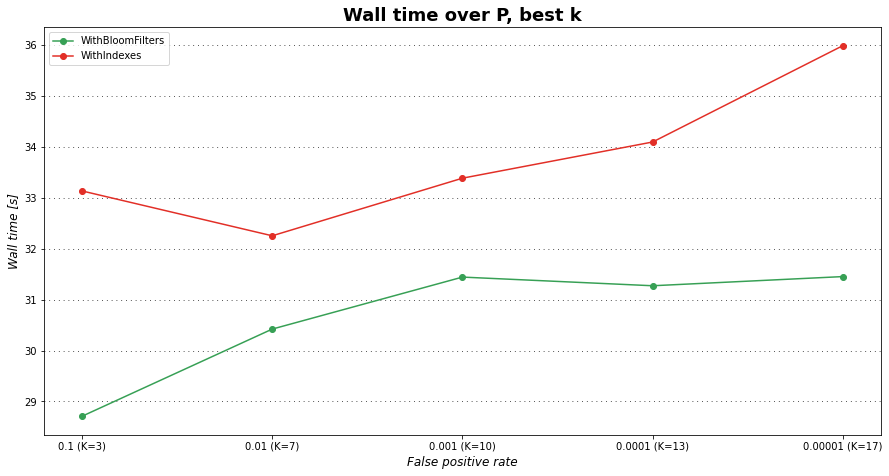

In [37]:
K = ['0']
P = ['0.1','0.01','0.001','0.0001','0.00001']
X = [f"{p} (K={params[f'P{p}K0']['K']})" for p in ['0.1','0.01','0.001','0.0001','0.00001']]

VERSIONS = ['WithBloomFilters','WithIndexes']

wallTime = [[hadoop_aggregate[f'WithBloomFiltersP{p}K{k}']['wallTime']['avg'] for p in P] for k in K] + \
                [[hadoop_aggregate[f'WithIndexesP{p}K{k}']['wallTime']['avg'] for p in P] for k in K]

error = [[hadoop_aggregate[f'WithBloomFiltersP{p}K{k}']['wallTime']['std'] for p in P] for k in K] + \
                [[hadoop_aggregate[f'WithIndexesP{p}K{k}']['wallTime']['std'] for p in P] for k in K]

legend = [f'{version}' for version in VERSIONS ]

plot_data('hadoop_wallTimeP_bestK', X, wallTime, legend, ['False positive rate', 'Wall time [s]'], 
          title='Wall time over P, best k', colors=sns.color_palette('Greens_d', len(K)) + sns.color_palette('Reds_d', len(K)), 
          auto_range=True)

* Wall time over mappers

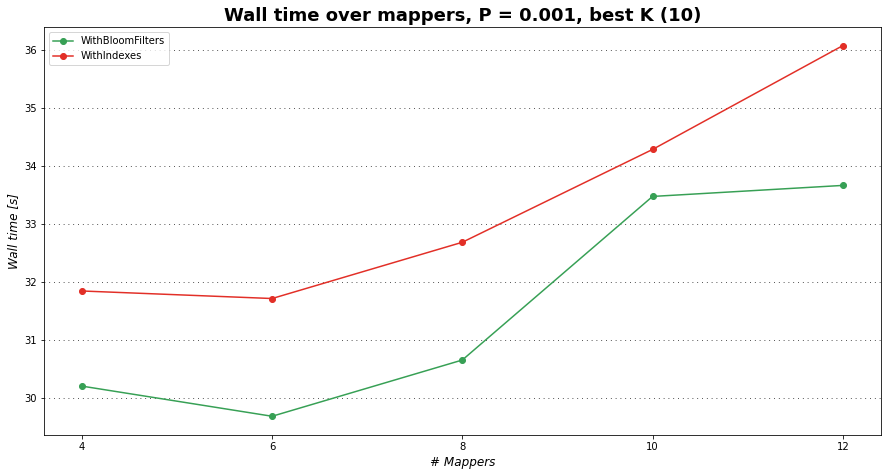

In [39]:
MAP = ['4', '6', '8', '10', '12']
MAP_P = '0.001'
MAP_K = '0'
VERSIONS = ['WithBloomFilters', 'WithIndexes']

wallTime = [[hadoop_aggregate[f'WithBloomFiltersP{MAP_P}K{MAP_K}MAP{map}']['wallTime']['avg'] for map in MAP]] + \
                [[hadoop_aggregate[f'WithIndexesP{MAP_P}K{MAP_K}MAP{map}']['wallTime']['avg'] for map in MAP] ]

error = [[hadoop_aggregate[f'WithBloomFiltersP{MAP_P}K{MAP_K}MAP{map}']['wallTime']['std'] for map in MAP]] + \
                [[hadoop_aggregate[f'WithIndexesP{MAP_P}K{MAP_K}MAP{map}']['wallTime']['std'] for map in MAP] ]

legend = [f'{version}' for version in VERSIONS ]

plot_data('hadoop_wallTimeMap', MAP, wallTime, legend, ['# Mappers', 'Wall time [s]'], 
          title=f'Wall time over mappers, P = {MAP_P}, best K ({params["P0.001K0MAP4"]["K"]})', colors=sns.color_palette('Greens_d', 1) + sns.color_palette('Reds_d', 1), 
          auto_range=True)

* Hadoop vs Spark

[[0.88, 1.42, 1.23, 0.99, 0.55], [2.04, 0.85, 1.21, 1.03, 0.67], [2.56, 3.96, 3.74, 3.83, 2.16], [2.13, 3.06, 4.49, 4.3, 4.23]]


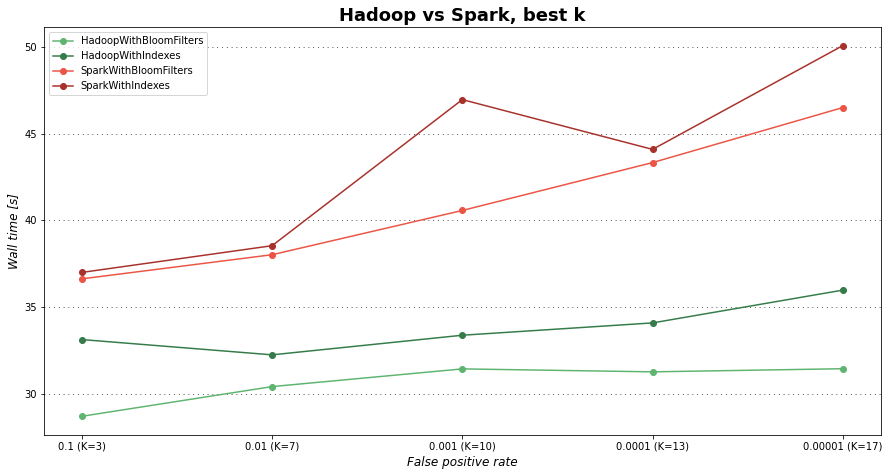

In [42]:
K = ['0']
P = ['0.1','0.01','0.001','0.0001','0.00001']
X = [f"{p} (K={params[f'P{p}K0']['K']})" for p in ['0.1','0.01','0.001','0.0001','0.00001']]

VERSIONS = ['WithBloomFilters','WithIndexes']

wall_time = [[hadoop_aggregate[f'WithBloomFiltersP{p}K{k}']['wallTime']['avg'] for p in P] for k in K] + \
                [[hadoop_aggregate[f'WithIndexesP{p}K{k}']['wallTime']['avg'] for p in P] for k in K] + \
                [[spark_aggregate[f'WithBloomFiltersP{p}K{k}']['wallTime']['avg'] for p in P] for k in K] + \
                [[spark_aggregate[f'WithIndexesP{p}K{k}']['wallTime']['avg'] for p in P] for k in K]
         
error = [[hadoop_aggregate[f'WithBloomFiltersP{p}K{k}']['wallTime']['std'] for p in P] for k in K] + \
                [[hadoop_aggregate[f'WithIndexesP{p}K{k}']['wallTime']['std'] for p in P] for k in K] + \
                [[spark_aggregate[f'WithBloomFiltersP{p}K{k}']['wallTime']['std'] for p in P] for k in K] + \
                [[spark_aggregate[f'WithIndexesP{p}K{k}']['wallTime']['std'] for p in P] for k in K]
       
legend = [f'{app}{version}' for app in ['Hadoop','Spark'] for version in VERSIONS ]
print(error)
plot_data('hadoopSpark_wallTimeP_bestK', X, wall_time, legend, ['False positive rate', 'Wall time [s]'], 
          title='Hadoop vs Spark, best k', colors=sns.color_palette('Greens_d', 2) + sns.color_palette('Reds_d', 2), 
          auto_range=True)

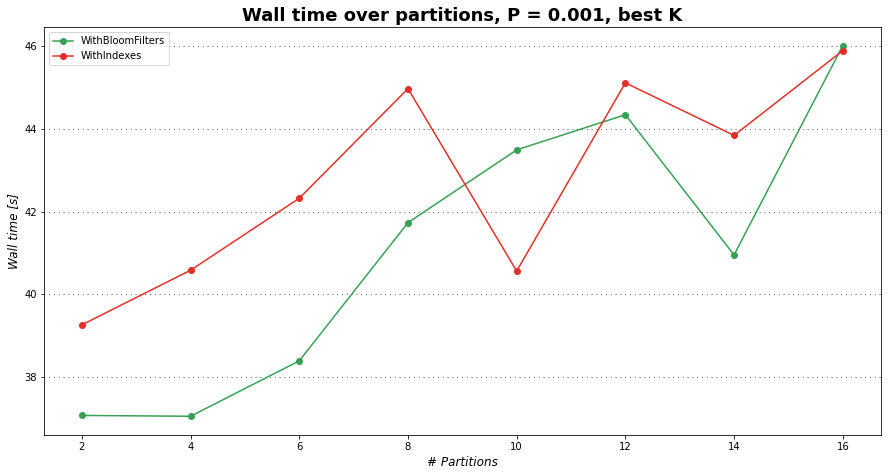

In [24]:
MAP = ['2', '4', '6', '8', '10', '12', '14' ,'16']
MAP_P = '0.001'
MAP_K = '0'
VERSIONS = ['WithBloomFilters', 'WithIndexes']

wallTime = [[spark_aggregate[f'WithBloomFiltersP{MAP_P}K{MAP_K}MAP{map}']['wallTime']['avg'] for map in MAP]] + \
                [[spark_aggregate[f'WithIndexesP{MAP_P}K{MAP_K}MAP{map}']['wallTime']['avg'] for map in MAP] ]

error = [[spark_aggregate[f'WithBloomFiltersP{MAP_P}K{MAP_K}MAP{map}']['wallTime']['std'] for map in MAP]] + \
                [[spark_aggregate[f'WithIndexesP{MAP_P}K{MAP_K}MAP{map}']['wallTime']['std'] for map in MAP] ]

legend = [f'{version}' for version in VERSIONS ]

plot_data('spark_wallTimeMap', MAP, wallTime, legend, ['# Partitions', 'Wall time [s]'], 
          title=f'Wall time over partitions, P = {MAP_P}, best K', colors=sns.color_palette('Greens_d', 1) + sns.color_palette('Reds_d', 1), 
          auto_range=True)